# Prova 2

import dos módulos básicos

In [530]:
# always yielding a real result, even dividing two integers
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import datetime as dt
from dateutil.relativedelta import relativedelta
from functools import reduce
import operator

# plot inline
%matplotlib inline

Carregando dados de feriados: cdi e bmf.
Fonte: [anbima](http://www.anbima.com.br/feriados/feriados.asp)

In [531]:
feriado_arq = 'feriados.xlsx'
feriado_cdi = pd.read_excel(feriado_arq,'cdi')
feriado_bmf = pd.read_excel(feriado_arq,'bmf')

Carregando dados de mercado

In [532]:
mkt_series_arq = 'BBergValues.xlsx'
usdbrl=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="A:E")
ptax=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="G:H")
ibov=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="J:M")
di1f21=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="O:S")
cdi=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="U:V")
cds5y=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="X:AB")
vol1m_off=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AD:AH")
vol3m_off=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AJ:AN")
vol12m_off=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AP:AT")
swpprecdi1m=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AV:AZ")
swpprecdi3m=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BB:BF")
swpprecdi12m=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BH:BL")
fwd1m_on=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BN:BR")
fwd3m_on=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BT:BX")
fwd12m_on=pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BZ:CD")

In [681]:
vol=pd.DataFrame(vol1m_off['PX_LAST'].values,columns=[1],index=vol1m_off.index)
vol[3]=vol3m_off['PX_LAST'].values
vol[12]=vol12m_off['PX_LAST'].values

fwd=pd.DataFrame(usdbrl['PX_LAST'].values,columns=[0],index=usdbrl.index)
fwd[1]=fwd1m_on['PX_LAST'].values
fwd[3]=fwd3m_on['PX_LAST'].values
fwd[12]=fwd12m_on['PX_LAST'].values

pre=pd.DataFrame(cdi['PX_LAST'].values,columns=[0],index=cdi.index)
pre[1]=swpprecdi1m['PX_LAST'].values
pre[3]=swpprecdi3m['PX_LAST'].values
pre[12]=swpprecdi12m['PX_LAST'].values

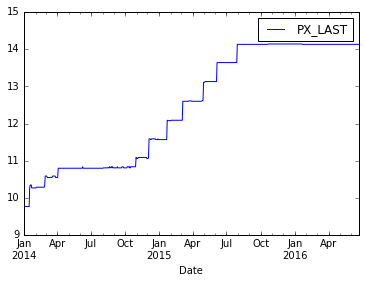

In [658]:
cdi.plot()

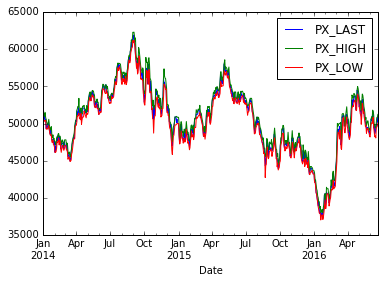

In [5]:
ibov.plot()

## Questão 1
___

Como estimar o risco dos portfolios do fundo a partir das séries de preços? Aponte as diferenças entre como
estimar o risco entre os diferentes tipos de séries. Assuma que esse cálculo está sendo feito em 31-Mar-2016.

## Questão 2
___

Um trader olhou o gráfico abaixo e pensou em uma estratégia.

![alt text](images/Capture.png "BRAZIL CDS USD SR 5Y D1")

**a)** Qual a estratégia que você acha que ele pensou?

**b)** Faz sentido? Qual a proporção dos ativos? Ela é fixa?

**c)** Se ele tivesse entrado no trade em 13-Abr-2016, qual teria sido o máximo drawdown (perda) dele no
período entre 13-Abr-2016 e 22-Jun-2016? Assuma notional de BRL 1MM.

**d)** A estimativa de risco que você teria feito teria estimado corretamente esse resultado?

**e)** Acrescente Ibovespa como uma estratégia (não esqueça do funding!); você faria algum novo trade?

## Questão 3
___

Em 30-Jun-2015 vários traders compraram opções de compra de USD (venda de BRL) ATMF para diferentes
prazos. Use os dados anexos, interpolação linear para spot e forwards, e a interpolação adequada para vols
ATMF (vol forward constante, variância efetiva é a soma das variâncias efetivas) para estimar os resultados
finais e perdas máximas de cada um dos traders.

Definindo a função BS para ser utilizada na precificação das opções

In [587]:
def bsv(phi,F,K,discount,vol,t):
    if(t>0):
        # calculate d1 and d2
        sigma_rt = vol*np.sqrt(t)
        d1=(np.log(F/K)+(vol**2/2)*t)/(sigma_rt)
        d2=d1-sigma_rt

        # calculate N(d1) and N(d2)
        Nd1=st.norm.cdf(phi*d1)
        Nd2=st.norm.cdf(phi*d2)
        delta=phi*Nd1*discount
        premium=phi*(F*Nd1-K*Nd2)*discount
    else:
        delta=0
        premium=max(phi*(F-K),0)
        
    return [premium,delta]

Definindo função para fazer a interpolação da vol:

In [589]:
def interpolaVol(dt0,v0,dt1,v1,dt):
    vv0=v0**2
    vv1=v1**2
    d0=dt0.toordinal()
    d1=dt1.toordinal()
    d=dt.toordinal()
    
    vv=((1/(d1-d0))*(vv1*d1*(d-d0)+vv0*d0*(d1-d)))/d
    return np.sqrt(vv)

Definindo a função para inicializar o DataFrame com as séries de acordo com o prazo (tenor)

In [769]:
def portf_initdf(start,months,usdbrl,cdi,fwd_tenor,vol_tenor,swpprecdi_tenor):
    term=relativedelta(months=months)
    end=start+term
    s=pd.Series(usdbrl['PX_LAST'][start:end])
    df=pd.DataFrame(s.index)
    df['t']=[(end.toordinal()-i.toordinal())/365 for i in df['Date']]
    df['tenor']=[i+term for i in s.index]
    df['usdbrl']=usdbrl['PX_LAST'][start:end].values
    df['cdi']=cdi['PX_LAST'][start:end].values/100
    df['cdi']=cdi['PX_LAST'][start:end].values/100
    cdiprod=[reduce(operator.mul,(1+df['cdi'][0:i])**(1/252),1) for i in range(1,len(df))]
    cdiprod.insert(0,1)
    df['cdiprod']=cdiprod
    df['fwd_tenor']=fwd_tenor[months][start:end].values
    df['vol_tenor']=vol_tenor[months][start:end].values/100
    df['pre_tenor']=swpprecdi_tenor[months][start:end].values/100
    df['strike']=df['fwd_tenor'][0]
    
    #interpolações
    if(months==1):
        tenor_short=df['Date']
        fwd_short=df['usdbrl']
        vol_short=df['vol_tenor']
        pre_short=df['cdi']
 
    if(months==3):
        tenor_short=[i+relativedelta(months=1) for i in s.index]
        fwd_short=fwd[1][start:end]
        vol_short=vol[1][start:end]/100
        pre_short=pre[1][start:end]/100
        
    if(months==12):
        tenor_short=[i+relativedelta(months=3) for i in s.index]
        fwd_short=fwd[3][start:end]
        vol_short=vol[3][start:end]/100
        pre_short=pre[3][start:end]/100
 
    df['fwd']=[fwd_short[i]+(df['fwd_tenor'][i]-fwd_short[i])*((end-tenor_short[i])/(df['tenor'][i]-tenor_short[i])) for i in df['Date'].index]
    df['vol']=[interpolaVol(tenor_short[i],vol_short[i],df['tenor'][i],df['vol_tenor'][i],end) for i in df['Date'].index]
    df['discount']=[pre_short[i]+(df['pre_tenor'][i]-pre_short[i])*((end-tenor_short[i])/(df['tenor'][i]-tenor_short[i])) for i in df['Date'].index]
    df['discount']=(1+df['discount'])**[-(end.toordinal()-i.toordinal())/365 for i in df['Date']]
    df=df.join(pd.DataFrame([bsv(call,df['fwd'][i],df['strike'][i],df['discount'][i],df['vol'][i],df['t'][i]) for i in df['Date'].index],columns=['premium','delta']))
    
    return df

In [770]:
portf_initdf(start,3,usdbrl,cdi,fwd,vol,pre)

,Date,t,tenor,usdbrl,cdi,cdiprod,fwd_tenor,vol_tenor,pre_tenor,strike,fwd,vol,discount,premium,delta
0,2015-06-30,0.252055,2015-09-30,3.1030,0.1364,1.000000,3.2018,0.15825,0.140176,3.2018,3.201800,0.158250,0.967475,0.098157,0.499066
1,2015-07-01,0.249315,2015-10-01,3.1492,0.1364,1.000508,3.2487,0.15823,0.140454,3.2018,3.247613,0.158292,0.967777,0.122130,0.567873
2,2015-07-02,0.246575,2015-10-02,3.0967,0.1364,1.001015,3.1941,0.15380,0.140722,3.2018,3.191998,0.153755,0.968084,0.089575,0.483276
3,2015-07-03,0.243836,2015-10-03,3.1341,0.1364,1.001523,3.2342,0.15417,0.140665,3.2018,3.230944,0.153972,0.968458,0.109241,0.544713
4,2015-07-06,0.235616,2015-10-06,3.1376,0.1364,1.002032,3.2357,0.15392,0.140265,3.2018,3.229297,0.152791,0.969612,0.106171,0.543523
5,2015-07-07,0.232877,2015-10-07,3.1863,0.1364,1.002540,3.2856,0.15743,0.140680,3.2018,3.278026,0.156984,0.969895,0.136453,0.617097
6,2015-07-08,0.230137,2015-10-08,3.2353,0.1364,1.003049,3.3364,0.15997,0.139951,3.2018,3.327613,0.159873,0.970378,0.169928,0.684801
7,2015-07-09,0.227397,2015-10-09,3.2130,0.1364,1.003558,3.3367,0.15920,0.140218,3.2018,3.326874,0.159215,0.970690,0.168618,0.685622
8,2015-07-10,0.224658,2015-10-10,3.1599,0.1364,1.004067,3.2576,0.15942,0.139615,3.2018,3.246780,0.158929,0.971142,0.117527,0.571205
9,2015-07-13,0.216438,2015-10-13,3.1344,0.1364,1.004577,3.2316,0.15977,0.139833,3.2018,3.218110,0.157567,0.972164,0.099386,0.527103


Definindo a função para cálculo do portfolio sem fazer o hedging:

In [675]:
def calc_portf_semhedge(start,months,usdbrl,cdi,fwd_tenor,vol_tenor,swpprecdi_tenor):

    #init data
    df=portf_initdf(start,months,usdbrl,cdi,fwd_tenor,vol_tenor,swpprecdi_tenor)

    #caixa do prêmio
    df['cfwprem']=-df['premium'][0]*df['cdiprod']

    #portfolio
    df['portf']=df['premium']+df['cfwprem']

    return df


**a)** O primeiro comprou uma opção de 1m e carregou sem hedge até o final.

In [689]:
#traderA=calc_portf_semhedge(start,1,usdbrl,cdi,fwd1m_on,vol1m_off,swpprecdi1m)
traderA=calc_portf_semhedge(start,1,usdbrl,cdi,fwd,vol,pre)
traderA

,Date,t,tenor,usdbrl,cdi,cdiprod,fwd_tenor,vol_tenor,pre_tenor,strike,fwd,vol,discount,premium,delta,cfwprem,portf
0,2015-06-30,0.082192,2015-07-30,3.1030,0.1364,1.000000,3.1364,0.16112,0.136743,3.1364,3.136400,0.16112,0.989521,0.057186,0.503877,-0.057186,0.000000
1,2015-07-01,0.079452,2015-08-01,3.1492,0.1364,1.000508,3.1824,0.16195,0.136777,3.1364,3.180258,0.16195,0.989868,0.081250,0.621812,-0.057215,0.024035
2,2015-07-02,0.076712,2015-08-02,3.0967,0.1364,1.001015,3.1300,0.15243,0.136766,3.1364,3.126777,0.15243,0.990217,0.047599,0.474705,-0.057244,-0.009646
3,2015-07-03,0.073973,2015-08-03,3.1341,0.1364,1.001523,3.1680,0.15010,0.136767,3.1364,3.163626,0.15010,0.990565,0.065434,0.586198,-0.057273,0.008161
4,2015-07-06,0.065753,2015-08-06,3.1376,0.1364,1.002032,3.1706,0.14202,0.136944,3.1364,3.163148,0.14202,0.991603,0.059864,0.594216,-0.057302,0.002562
5,2015-07-07,0.063014,2015-08-07,3.1863,0.1364,1.002540,3.2196,0.15350,0.137075,3.1364,3.211006,0.15350,0.991948,0.094129,0.729525,-0.057332,0.036798
6,2015-07-08,0.060274,2015-08-08,3.2353,0.1364,1.003049,3.2694,0.15923,0.137130,3.1364,3.259500,0.15923,0.992295,0.132786,0.835905,-0.057361,0.075426
7,2015-07-09,0.057534,2015-08-09,3.2130,0.1364,1.003558,3.2701,0.15930,0.137130,3.1364,3.251681,0.15930,0.992646,0.125632,0.826301,-0.057390,0.068242
8,2015-07-10,0.054795,2015-08-10,3.1599,0.1364,1.004067,3.1916,0.15640,0.137198,3.1364,3.180352,0.15640,0.992994,0.070895,0.650251,-0.057419,0.013476
9,2015-07-13,0.046575,2015-08-13,3.1344,0.1364,1.004577,3.1683,0.14915,0.137439,3.1364,3.152990,0.14915,0.994039,0.048923,0.568015,-0.057448,-0.008525


**b)**  O segundo comprou uma opção de 1m e fez o delta hedge até o final.

**c)** O terceiro comprou uma opção de 3m e carregou sem hedge até o final.

In [772]:
traderC=calc_portf_semhedge(start,3,usdbrl,cdi,fwd,vol,pre)
traderC

,Date,t,tenor,usdbrl,cdi,cdiprod,fwd_tenor,vol_tenor,pre_tenor,strike,fwd,vol,discount,premium,delta,cfwprem,portf
0,2015-06-30,0.252055,2015-09-30,3.1030,0.1364,1.000000,3.2018,0.15825,0.140176,3.2018,3.201800,0.158250,0.967475,0.098157,0.499066,-0.098157,0.000000
1,2015-07-01,0.249315,2015-10-01,3.1492,0.1364,1.000508,3.2487,0.15823,0.140454,3.2018,3.247613,0.158292,0.967777,0.122130,0.567873,-0.098207,0.023923
2,2015-07-02,0.246575,2015-10-02,3.0967,0.1364,1.001015,3.1941,0.15380,0.140722,3.2018,3.191998,0.153755,0.968084,0.089575,0.483276,-0.098257,-0.008682
3,2015-07-03,0.243836,2015-10-03,3.1341,0.1364,1.001523,3.2342,0.15417,0.140665,3.2018,3.230944,0.153972,0.968458,0.109241,0.544713,-0.098307,0.010935
4,2015-07-06,0.235616,2015-10-06,3.1376,0.1364,1.002032,3.2357,0.15392,0.140265,3.2018,3.229297,0.152791,0.969612,0.106171,0.543523,-0.098356,0.007814
5,2015-07-07,0.232877,2015-10-07,3.1863,0.1364,1.002540,3.2856,0.15743,0.140680,3.2018,3.278026,0.156984,0.969895,0.136453,0.617097,-0.098406,0.038047
6,2015-07-08,0.230137,2015-10-08,3.2353,0.1364,1.003049,3.3364,0.15997,0.139951,3.2018,3.327613,0.159873,0.970378,0.169928,0.684801,-0.098456,0.071472
7,2015-07-09,0.227397,2015-10-09,3.2130,0.1364,1.003558,3.3367,0.15920,0.140218,3.2018,3.326874,0.159215,0.970690,0.168618,0.685622,-0.098506,0.070111
8,2015-07-10,0.224658,2015-10-10,3.1599,0.1364,1.004067,3.2576,0.15942,0.139615,3.2018,3.246780,0.158929,0.971142,0.117527,0.571205,-0.098556,0.018971
9,2015-07-13,0.216438,2015-10-13,3.1344,0.1364,1.004577,3.2316,0.15977,0.139833,3.2018,3.218110,0.157567,0.972164,0.099386,0.527103,-0.098606,0.000780


**d)** O quarto comprou uma opção de 3m e fez o delta hedge até o final.

**e)** O quinto comprou uma opção de 12m e carregou sem hedge até o final.

In [776]:
traderE=calc_portf_semhedge(start,12,usdbrl,cdi,fwd,vol,pre)
traderE

,Date,t,tenor,usdbrl,cdi,cdiprod,fwd_tenor,vol_tenor,pre_tenor,strike,fwd,vol,discount,premium,delta,cfwprem,portf
0,2015-06-30,1.002740,2016-06-30,3.1030,0.1364,1.000000,3.4828,0.15985,0.142825,3.4828,3.482800,0.159850,0.874705,0.194332,0.465251,-0.194332,0.000000
1,2015-07-01,1.000000,2016-07-01,3.1492,0.1364,1.000508,3.5312,0.15985,0.143122,3.4828,3.530169,0.159844,0.874805,0.216817,0.494533,-0.194430,0.022386
2,2015-07-02,0.997260,2016-07-02,3.0967,0.1364,1.001015,3.4672,0.15865,0.141529,3.4828,3.465207,0.158615,0.876340,0.184569,0.454675,-0.194529,-0.009960
3,2015-07-03,0.994521,2016-07-03,3.1341,0.1364,1.001523,3.5058,0.15955,0.141051,3.4828,3.502826,0.159492,0.877022,0.203079,0.478859,-0.194628,0.008451
4,2015-07-06,0.986301,2016-07-06,3.1376,0.1364,1.002032,3.5085,0.15832,0.141249,3.4828,3.502526,0.158225,0.877837,0.200788,0.478933,-0.194726,0.006061
5,2015-07-07,0.983562,2016-07-07,3.1863,0.1364,1.002540,3.5618,0.16100,0.141015,3.4828,3.554744,0.160910,0.878322,0.229755,0.511493,-0.194825,0.034929
6,2015-07-08,0.980822,2016-07-08,3.2353,0.1364,1.003049,3.6156,0.16275,0.140553,3.4828,3.607448,0.162670,0.878995,0.259578,0.542746,-0.194924,0.064654
7,2015-07-09,0.978082,2016-07-09,3.2130,0.1364,1.003558,3.6159,0.16193,0.140553,3.4828,3.606729,0.161841,0.879307,0.258016,0.542824,-0.195023,0.062993
8,2015-07-10,0.975342,2016-07-10,3.1599,0.1364,1.004067,3.5281,0.16257,0.139290,3.4828,3.518228,0.162456,0.880558,0.213072,0.490448,-0.195122,0.017950
9,2015-07-13,0.967123,2016-07-13,3.1344,0.1364,1.004577,3.5031,0.16270,0.139563,3.4828,3.490219,0.162562,0.881297,0.199045,0.473384,-0.195221,0.003824


## Questão 4
___

**a)** Monte Carlo

**b)** PDE

implementação sugerida

In [ ]:
def grid(N,T,Nj,S,dx,vol,r,q,K,output='V'):
    dt = T / N
    if dx < vol * np.sqrt(3 * dt):
        print('Convergence error')
    mu = -(0.5)*(r-q)*vol**2
    emdx = np.exp(-dx)
    ppu = 0.5 * dt * ((vol / dx) ** 2 + mu / dx)
    ppm = 1.0-dt * (vol / dx) ** 2-r * dt
    ppd = 0.5 * dt * ((vol / dx) ** 2-mu / dx)
    St = np.full(2 * Nj + 1,0.)
    St[0] = S * np.exp(Nj * dx)
    for j in np.arange(1,2 * Nj + 1):
        St[j] = St[j-1]*emdx
    Ct = np.full((2 * Nj + 1,N + 1),np.nan)
    for j in np.arange(0,2 * Nj + 1):
        Ct[j,N] = np.max([St[j]-K,0])
    for i in np.arange(N-1,-1,-1):
        for k in np.arange(N-i,2 * Nj + 1-(N-i)):
            Ct[k,i] = ppu * Ct[k-1,i + 1]+ ppm * Ct[k,i + 1] + ppd * Ct[k + 1,i + 1]
        #Boundary
    #Boundary
    if output == 'G':
        return Ct
    else:
        return Ct[Nj,0]
